<a href="https://colab.research.google.com/github/deborahchang/projects/blob/Mortality_Project/Copy_of_Data_102_Final_Project_Causal_Inference_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
!pip install causalinference
from causalinference import CausalModel


drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Mortality/In_hospital_mortality.csv'
mortality = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
mortality = mortality[['age', 'gendera', 'BMI', 'diabetes']].dropna()
mortality.head()

,age,gendera,BMI,diabetes
0,72,1,37.588179,1
2,83,2,26.572634,0
3,43,2,83.264629,0
4,75,2,31.824842,0
5,76,1,24.262293,0


In [ ]:
filtered_data_ages_40_to_99 = mortality[(mortality['age'] >= 40) & (mortality['age'] <= 99)]
mortality['age_bin'] = pd.cut(filtered_data_ages_40_to_99['age'], bins=range(40, 110, 10), right=False)
mortality.head()

,age,gendera,BMI,diabetes,age_bin
0,72,1,37.588179,1,"[70, 80)"
2,83,2,26.572634,0,"[80, 90)"
3,43,2,83.264629,0,"[40, 50)"
4,75,2,31.824842,0,"[70, 80)"
5,76,1,24.262293,0,"[70, 80)"


In [ ]:
# Split dataset into treatment and control
treatment_group = mortality[mortality['diabetes']==1]
control_group = mortality[mortality['diabetes']==0]


print('Size of treatment group:', len(treatment_group))
print('Size of control group:', len(control_group))

Size of treatment group: 416
Size of control group: 546


In [ ]:
# Matching algorithm, returns calculated ATE from matches
# matching on 'age_bin' and 'gendera'

def calculate_matching_ATE(treatment_group, control_group):
  # Initialize empty list to store all individual treatment effects
  individual_effects = []

  # Iterate through each treated individual to find matches
  for _, treated_row in treatment_group.iterrows():
    matching_control_rows = control_group[
        (control_group['age_bin'] == treated_row['age_bin']) &
        (control_group['gendera'] == treated_row['gendera'])
    ]
    # If there are matching control individuals, calculate individ effects
    if not matching_control_rows.empty:
      avg_control_bmi = matching_control_rows['BMI'].mean()
      individual_effect = treated_row['BMI'] - avg_control_bmi
      individual_effects.append(individual_effect)

  # Repeat process for each control individual
  for _, control_row in control_group.iterrows():
    matching_treated_rows = treatment_group[
        (treatment_group['age_bin'] == control_row['age_bin']) &
        (treatment_group['gendera'] == control_row['gendera'])
    ]
    # If there are matching control individuals, calculate individ effects
    if not matching_treated_rows.empty:
      avg_treated_bmi = matching_treated_rows['BMI'].mean()
      individual_effect = control_row['BMI'] - avg_treated_bmi
      individual_effects.append(individual_effect)

  # Calculate ATE
  ate = sum(individual_effects) / len(individual_effects)
  return ate

In [ ]:
ate = calculate_matching_ATE(treatment_group, control_group)
print('Average Treatment Effect (ATE):', ate)

Average Treatment Effect (ATE): -0.44031806620885067


In [ ]:
# Define confounders
confounders = ['age', 'gendera']

# Separate features (X) and target variable (Y)
X = mortality[confounders]
Y = mortality.loc[X.index, 'diabetes']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Fit logistic regression model to estimate propensity scores
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Predict propensity scores for the entire dataset
mortality['propensity_score'] = logreg.predict_proba(mortality[confounders])[:, 1]


# Split into treatment and control
treated_group = mortality[mortality['diabetes']==1]
untreated_group = mortality[mortality['diabetes']==0]

mortality.head()

,age,gendera,BMI,diabetes,age_bin,propensity_score
0,72,1,37.588179,1,"[70, 80)",0.465139
2,83,2,26.572634,0,"[80, 90)",0.377617
3,43,2,83.264629,0,"[40, 50)",0.505589
4,75,2,31.824842,0,"[70, 80)",0.402449
5,76,1,24.262293,0,"[70, 80)",0.452178


In [ ]:
# Treated = A
# Untreated = B
def individual_adjustments(df, a_group, b_group, k_neighbors=2):
    adjusted_bmi_values = []

    # For treated group
    for _, a_row in a_group.iterrows():
        # Find the k closest untreated rows based on propensity score
        nn = NearestNeighbors(n_neighbors=k_neighbors, metric='euclidean')
        nn.fit(b_group[['propensity_score']])
        distances, indices = nn.kneighbors(a_row[['propensity_score']].values.reshape(1, -1))

        # Extract the closest untreated rows
        closest_b_rows = b_group.iloc[indices.flatten()]

        # Calculate the average BMI for the closest untreated group
        average_b_bmi = closest_b_rows['BMI'].mean()

        # Adjust the treated row's BMI
        adjusted_bmi = a_row['BMI'] - average_b_bmi
        adjusted_bmi_values.append(adjusted_bmi)

    return adjusted_bmi_values

# Perform individual adjustments for treated individuals
treated_adjustments = individual_adjustments(mortality, treated_group, untreated_group, k_neighbors=2)
untreated_adjustments = individual_adjustments(mortality, untreated_group, treated_group, k_neighbors=2)

# Combine adjustments and calculate overall average
all_adjustments = np.concatenate([untreated_adjustments, treated_adjustments])
overall_average_adjustment = np.mean(all_adjustments)

print("Overall Average Adjustment:", overall_average_adjustment)

# Overall Average Adjustment: -0.6021377127754677


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature n

Overall Average Adjustment: -0.6021377127754677


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [ ]:
def approximate_matching(mortality, k=1):
    nn = NearestNeighbors(n_neighbors=k, metric='euclidean')
    nn.fit(mortality[mortality['diabetes'] == 0][['propensity_score']])

    # Finding nearest neighbors for each individual in the treatment group
    distances, indices = nn.kneighbors(mortality[mortality['diabetes'] == 1][['propensity_score']])

    # Adding a column to the original DataFrame with the index of the match in the control group
    matched_control_group = mortality[mortality['diabetes'] == 0].iloc[indices.flatten()].copy()
    matched_control_group['matched_treatment_index'] = indices.flatten()

    if len(matched_control_group) < len(control_group):
        print(f"Warning: Only {len(matched_control_group)} matches found for {len(control_group)} control samples.")

    return matched_control_group

# Apply approximate matching
matched_control_group = approximate_matching(mortality, k=1)
matched_control_group.head()


,age,gendera,glucose,BMI,diabetes,propensity_score,matched_treatment_index
433,1.127030,1,-0.591973,25.112724,0,0.344835,207
4,0.095101,2,-0.083164,31.824842,0,0.368815,2
534,1.642994,2,-0.804707,22.819490,0,0.239810,260
875,-1.747629,2,-1.128996,30.226818,0,0.230994,397
5,0.168810,1,-1.005766,24.262293,0,0.290634,3


In [ ]:

causal_model = CausalModel(Y, mortality['diabetes'].values, mortality[confounders].values)
causal_model.est_propensity_s()
causal_model.est_via_matching(matches=matched_control_group['matched_treatment_index'].values, bias_adj=True)

print(causal_model.summary_stats)


ValueError: ignored

Link to our proposal: https://docs.google.com/document/d/1QfpcDD5wOZ9-yUt8zdUWcXqv9lLYhE3tuULxoUNjcn0/edit

Propensity scores are often used to reweight the population to approximate it. As we learned in lecture, inverse propensity weighting tries to undo or compensate for the effect of confounders by reweighting the outcome variables based on the treatment and confounders.

In lecture, the example was binary - in our dataset, we must work for continuous confounders. Therefore,we must use logistic regression to determine for each row, what is the probability (based on the confounders) of that row ending up in the treatment group?

For propensity score weighting, the following method was used:

In [ ]:
mortality = pd.read_csv(file_path)

gender_mapping = {1: 'Male', 2: 'Female'}
mortality['gender_label'] = mortality['gendera'].map(gender_mapping)
mortality = mortality[['age', 'gender_label', 'BMI', 'Systolic blood pressure', 'Diastolic blood pressure', 'diabetes', 'outcome']].dropna()
mortality['outcome'] = mortality['outcome'].astype(int)
data = mortality.copy()

#Define covariates
covariates = ['age', 'gender_label', 'Systolic blood pressure', 'Diastolic blood pressure']
data['diabetes'] = data['diabetes'].astype(int)
data['gender_label'] = data['gender_label'].apply(lambda x: 1 if x == 'Male' else 0)

Here, the variables that we want to study for the propensity score weighting is defined.

In [ ]:
#Logistic regression for propensity scores
log_reg = LogisticRegression()
data['propensity_score'] = log_reg.fit(data[covariates], data['diabetes']).predict_proba(data[covariates])[:, 1]

Here, a logistic regression model is made to fit the propensity scores for each individual - these are essentially the probability of having diabetes given the covariates.

In [ ]:
#Calculating weights
data['weight'] = np.where(data['diabetes'] == 1, 1 / data['propensity_score'], 1 / (1 - data['propensity_score']))

The "weight" for each individual based on their propensity score is calculated. For example, those with diabetes (treatment group) will be divided by the propensity score, while those without diabetes (control group) would get the inverse of one minus their propensity score. This is to re-weight the "importance" of the different records in the groups - to find units that were less likely to end up in the group that they did, and give those higher weight.



In [ ]:
#Calculating weighted mean for BMI among the diabetic group
bmi_d = np.sum(data.loc[data['diabetes'] == 1, 'BMI'] * data.loc[data['diabetes'] == 1, 'weight'])
total_d = np.sum(data.loc[data['diabetes'] == 1, 'weight'])
mean_diabetic = bmi_d / total_d

#Calculating weighted mean for BMI among the non-diabetic group
bmi_n = np.sum(data.loc[data['diabetes'] == 0, 'BMI'] * data.loc[data['diabetes'] == 0, 'weight'])
total_n = np.sum(data.loc[data['diabetes'] == 0, 'weight'])
mean_n = bmi_n / total_n

Once weights have been calculated, the weighted means of the two groups (diabetic and non-diabetic) are calculated by multiplying the BMI by the weight for each individual, then summing these products and dividing by the sum of the weights.

In [ ]:
#Calculating the effect
effect_estimate = mean_diabetic - mean_n
print('IPW estimate:', effect_estimate)

IPW estimate: 2.1407032170760907


The interpretation would be that the estimated effect of diabetes on BMI is 2.14, or the IPW estimate. In other words, on average, individuals with diabetes have a BMI that is 2.14 points higher than those without diabetes, after accounting for differences in age, gender, and blood pressure.

**EDA**

In [ ]:
# preprocessing steps

gender_mapping = {1: 'Male', 2: 'Female'}
mortality['gender_label'] = mortality['gendera'].map(gender_mapping)
mortality = mortality[['age', 'gender_label', 'BMI', 'glucose', 'diabetes']].dropna()
mortality['outcome'] = mortality['outcome'].astype(int)

In [ ]:
mortality.head()

,age,gender_label,BMI,Systolic blood pressure,Diastolic blood pressure,diabetes,outcome
0,72,Male,37.588179,155.866667,68.333333,1,0
2,83,Female,26.572634,135.333333,61.375000,0,0
3,43,Female,83.264629,126.400000,73.200000,0,0
4,75,Female,31.824842,156.560000,58.120000,0,0
5,76,Male,24.262293,118.100000,52.950000,0,0


In [ ]:
mortality.describe()

,age,BMI,Systolic blood pressure,Diastolic blood pressure,diabetes,outcome
count,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000
mean,73.689402,30.211160,117.575532,59.559210,0.433368,0.118573
std,13.550019,9.351745,17.209018,10.587133,0.495801,0.323455
min,19.000000,13.346801,75.000000,24.736842,0.000000,0.000000
25%,65.000000,24.326438,105.130435,52.263158,0.000000,0.000000
50%,77.000000,28.352286,115.545455,58.755556,0.000000,0.000000
75%,85.000000,33.641425,128.000000,65.434783,1.000000,0.000000
max,99.000000,104.970366,203.000000,107.000000,1.000000,1.000000


1. Visualization of BMI for each whether or not having diabetes: This visualization is critical in that it motivates asking the causal question of whether higher higher BMI causes the diagnoses of diabetes. From our histogram, we can observe there exists a difference between the distribution of BMI for diabetes and non-diabetes group, with diabetes group generally having higher BMI than non-diabetes group. This trend indicates a possible cause from BMI on diabetes.

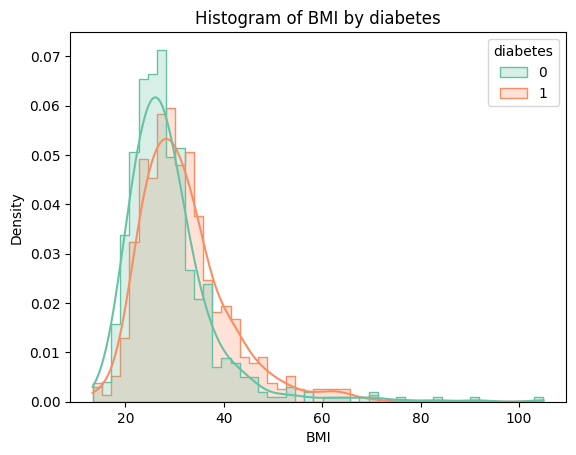

In [ ]:
sns.histplot(data=mortality, x='BMI', hue='diabetes', element='step', stat='density', common_norm=False, kde=True, palette='Set2')

plt.xlabel('BMI')
plt.ylabel('Density')
plt.title('Histogram of BMI by diabetes')
plt.show()

2. The following visualizations are built to discover potential confounders within the causal relationship specified above. We hypothesize that gender could be a confounder that could affect both Diabetes and BMI, so we plot gender with respect to Diabetes and BMI respectively. We discovered that compared with female, that are more males who have diabetes and less males who don't have diabetes, which indicate a potential associate between gender and diabetes. Moreover, the histogram demonstrates a higher density of male on younger ages for males than females, which possibly indicate an associate between gender and BMI.

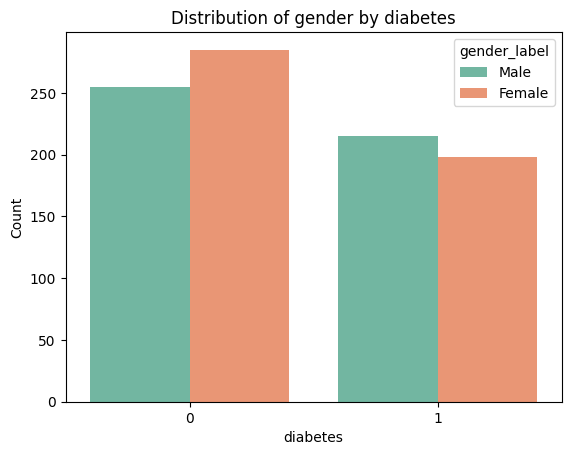

In [ ]:
# Visualization of gender on diabetes

sns.countplot(x='diabetes', hue='gender_label', data=mortality, palette='Set2')

plt.xlabel('diabetes')
plt.ylabel('Count')
plt.title('Distribution of gender by diabetes')
plt.show()

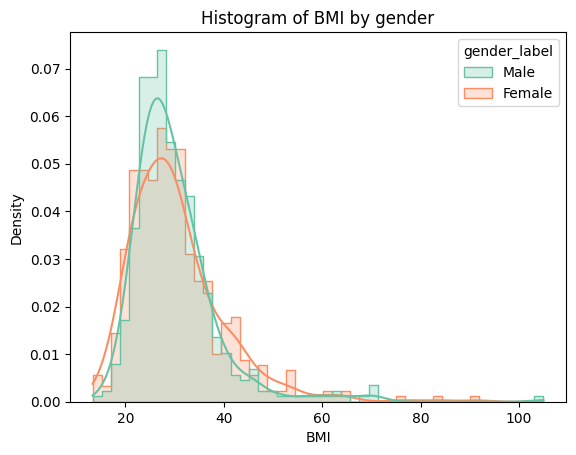

In [ ]:
# Visualization of BMI for each gender

sns.histplot(data=mortality, x='BMI', hue='gender_label', element='step', stat='density', common_norm=False, kde=True, palette='Set2')

plt.xlabel('BMI')
plt.ylabel('Density')
plt.title('Histogram of BMI by gender')
plt.show()

3. Visualization of age of people who died and people who did not die. We are interested in using multiple linear regression on predicting people's death using other variables. We ploted the histogram of age seperated by outcome, and we found a higher density of older people for those who died than those who did not die. This indicate a potential predictive power of age as a varaible within the multiple linear regression.

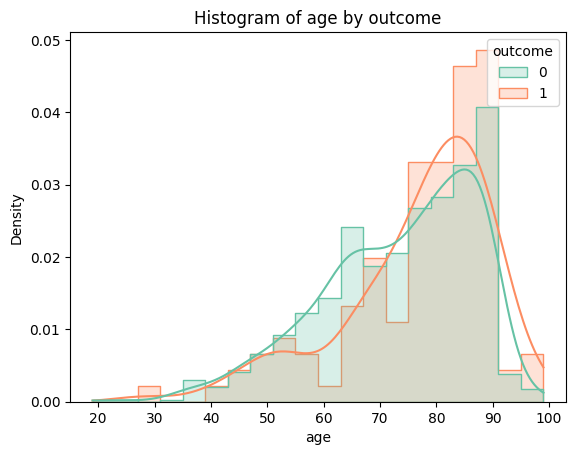

In [ ]:
sns.histplot(data=mortality, x='age', hue='outcome', element='step', stat='density', common_norm=False, kde=True, palette='Set2')

plt.xlabel('age')
plt.ylabel('Density')
plt.title('Histogram of age by outcome')
plt.show()

4. Additionally, we need to confirm that the class labels is balanced within our dataset. This ensures the accuracy of our model and we minimize the bias within our prediction. We do see that people who died are much fewer than the people who did not, which indicates a necessity of using techniques such as resampling.

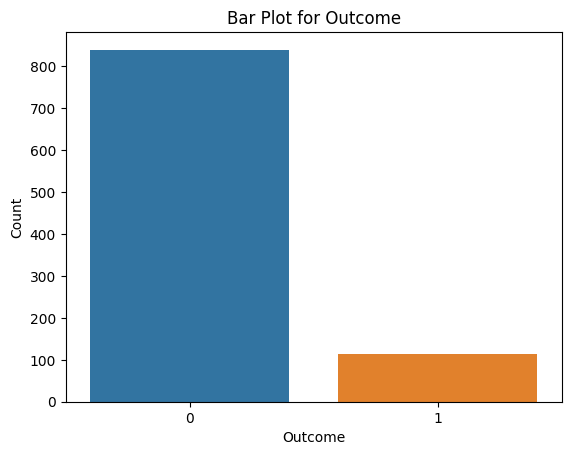

In [ ]:
sns.countplot(x='outcome', data = mortality)

plt.xlabel('Outcome')
plt.ylabel('Count')
plt.title('Bar Plot for Outcome')
plt.show()

Ages were unevenly distributed, so I grouped them in groups

In [ ]:

Q1 = mortality['BMI'].quantile(0.25)
Q3 = mortality['BMI'].quantile(0.75)
IQR = Q3 - Q1
# fall below Q1 - 1.5*IQR or above Q3 + 1.5*IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering
filtered_data = mortality[(mortality['BMI'] >= lower_bound) & (mortality['BMI'] <= upper_bound)]

#age groups
age_counts = filtered_data['age'].value_counts().sort_index()
age_bins = pd.cut(filtered_data['age'], bins=range(10, 110, 10), right=False)
age_group_counts = filtered_data.groupby(age_bins)['age'].count()
age_group_counts

age
[10, 20)       1
[20, 30)       0
[30, 40)      10
[40, 50)      34
[50, 60)      81
[60, 70)     171
[70, 80)     216
[80, 90)     369
[90, 100)     29
Name: age, dtype: int64

I then filtered because these age groups were also unevenly distributed. I then groupby diabetes to find chance of dieing and having diabetes.

In [ ]:
filtered_data_ages_40_to_99 = mortality[(mortality['age'] >= 40) & (mortality['age'] <= 99)]
age_bins_40_to_99 = pd.cut(filtered_data_ages_40_to_99['age'], bins=range(40, 110, 10), right=False)
average_diabetes_per_age_group = filtered_data_ages_40_to_99.groupby(age_bins_40_to_99)['diabetes'].mean()
average_diabetes_per_age_group

age
[40, 50)     0.465116
[50, 60)     0.593407
[60, 70)     0.481081
[70, 80)     0.429864
[80, 90)     0.382114
[90, 100)    0.413793
Name: diabetes, dtype: float64

In [ ]:
age_diabetes_corr = filtered_data_ages_40_to_99['age'].corr(filtered_data_ages_40_to_99['diabetes'])
age_diabetes_corr # as age increases, the likelihood of having diabetes decreases slightly.

-0.11542167082453114

In [ ]:
age_bmi_corr = filtered_data_ages_40_to_99['age'].corr(filtered_data_ages_40_to_99['BMI'])
age_bmi_corr #as age increases, BMI tends to decrease.

-0.3687990376493193

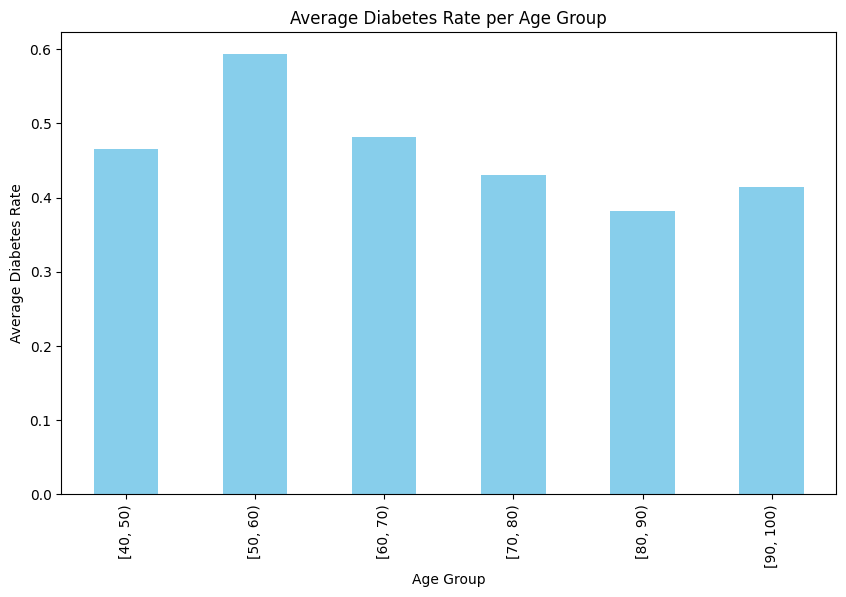

In [ ]:
plt.figure(figsize=(10, 6))
average_diabetes_per_age_group.plot(kind='bar', color='skyblue')
plt.title('Average Diabetes Rate per Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Diabetes Rate')
plt.show()

In [ ]:
mortality.describe()

,age,BMI,Systolic blood pressure,Diastolic blood pressure,diabetes,outcome
count,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000
mean,73.689402,30.211160,117.575532,59.559210,0.433368,0.118573
std,13.550019,9.351745,17.209018,10.587133,0.495801,0.323455
min,19.000000,13.346801,75.000000,24.736842,0.000000,0.000000
25%,65.000000,24.326438,105.130435,52.263158,0.000000,0.000000
50%,77.000000,28.352286,115.545455,58.755556,0.000000,0.000000
75%,85.000000,33.641425,128.000000,65.434783,1.000000,0.000000
max,99.000000,104.970366,203.000000,107.000000,1.000000,1.000000
